## Setup

In [ ]:
%%capture
!pip install mitiq

In [ ]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

import cirq
import mitiq
from mitiq import cdr, ddd, pec, rem, zne
from mitiq.benchmarks import generate_rb_circuits
from mitiq import MeasurementResult, Observable, PauliString, raw

In [ ]:
%matplotlib inline

## Experiments

### Executor

In [ ]:
def execute(circuit: cirq.Circuit, noise_level: float = 0.005, p0: float = 0.05, p1: float = 0.05) -> MeasurementResult:
    """Execute a circuit with depolarizing noise of strength ``noise_level`` and readout errors ...
    """
    measurements = circuit[-1]
    circuit =  circuit[:-1]
    circuit = circuit.with_noise(cirq.depolarize(noise_level))
    circuit.append(cirq.bit_flip(p0).on_each(circuit.all_qubits()))
    circuit.append(cirq.phase_flip(p1).on_each(circuit.all_qubits()))
    circuit.append(measurements)

    simulator = cirq.DensityMatrixSimulator()

    result = simulator.run(circuit, repetitions=10000)
    bitstrings = np.column_stack(list(result.measurements.values()))
    return MeasurementResult(bitstrings)

In [ ]:
observable = Observable(PauliString("ZI"), PauliString("IZ"))

### Utility functions

In [ ]:
import numpy as np
import plotly.graph_objects as go

def plot_surface_interactive(X, Y, Z):
    fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])

    fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                    autosize=False,
                    width=400, height=400)

    fig.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator


def plot_surface(X, Y, Z, x_labels=None, y_labels=None):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    if x_labels:
        ax.set_xticklabels([0] + x_labels)
    if y_labels:
        ax.set_yticklabels([0] + y_labels)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

### Experiment setup

In [ ]:
from mitiq.benchmarks import generate_rb_circuits, generate_ghz_circuit, generate_mirror_circuit, generate_w_circuit
from mitiq.ddd.rules import xx, yy, xyxy
from mitiq.zne.inference import ExpFactory, LinearFactory, PolyFactory, RichardsonFactory
from mitiq.zne.scaling.folding import fold_gates_at_random, fold_all, fold_global


rb_circuits = {
    "rb5": generate_rb_circuits(2, 5)[0],
    "rb10": generate_rb_circuits(2, 10)[0],
    "rb20": generate_rb_circuits(2, 20)[0],
}
circuits = {
    "rb5": generate_rb_circuits(2, 5)[0],
    "rb10": generate_rb_circuits(2, 10)[0],
    "rb20": generate_rb_circuits(2, 20)[0],
    "ghz5": generate_ghz_circuit(5),
    "ghz10": generate_ghz_circuit(10),
    "w5": generate_w_circuit(5),
    "w10": generate_w_circuit(10)
}
folds = {
    "local": partial(fold_gates_at_random, random_state=42),
    "all": partial(fold_all),
    "global": partial(fold_global)
}
factories = {
    "lin": LinearFactory(scale_factors=[1, 3]),
    "rich": RichardsonFactory(scale_factors=[1.0, 2.0, 3.0]),
    "poly": PolyFactory(scale_factors=[1, 1.5, 2, 2.5, 3], order=2),
    "exp": ExpFactory(scale_factors=[1, 3, 5])
}
rules = {"xx": xx, "yy": yy, "xyxy": xyxy}
probs = [0.1, 0.01, 0.05, 0.001, 0.005]

### DDD

In [ ]:
ddd_results = {}

print("\n================ DDD ================\n")
for i, (circuit_name, circuit) in enumerate(rb_circuits.items()):
    for j, (rule_name, rule) in enumerate(rules.items()):
        print(f"({i}, {j}) => Circuit: {circuit_name}, Rule: {rule_name}")

        executor = ddd.mitigate_executor(
            execute,
            observable=observable,
            rule=rule
        )

        result = executor(circuit)

        ideal_value = raw.execute(circuit, partial(execute, noise_level=0, p0=0, p1=0), observable).real
        noisy_value = raw.execute(circuit, execute, observable).real
        mitiq_value = result.real
        error = abs((ideal_value - mitiq_value) / ideal_value)
        rem_value = abs((ideal_value - mitiq_value) / (ideal_value - noisy_value))
        ddd_results[(i, j)] = [ideal_value, mitiq_value, error, rem_value]

        print(f"Mitigated value: {mitiq_value:.3f}")
        print(f"Error w Mitiq: {error:.3f}")
        print(f"REM w  Mitiq: {rem_value:.3f}")
        print("\n")


================ DDD ================

(0, 0) => Circuit: rb5, Rule: xx
Mitigated value: 1.227
Error w Mitiq: 0.386
REM w  Mitiq: 1.018


(0, 1) => Circuit: rb5, Rule: yy
Mitigated value: 1.239
Error w Mitiq: 0.381
REM w  Mitiq: 0.972


(0, 2) => Circuit: rb5, Rule: xyxy
Mitigated value: 1.243
Error w Mitiq: 0.379
REM w  Mitiq: 0.984


(1, 0) => Circuit: rb10, Rule: xx
Mitigated value: 0.812
Error w Mitiq: 0.594
REM w  Mitiq: 0.976


(1, 1) => Circuit: rb10, Rule: yy
Mitigated value: 0.822
Error w Mitiq: 0.589
REM w  Mitiq: 1.023


(1, 2) => Circuit: rb10, Rule: xyxy
Mitigated value: 0.813
Error w Mitiq: 0.594
REM w  Mitiq: 1.016


(2, 0) => Circuit: rb20, Rule: xx
Mitigated value: 0.458
Error w Mitiq: 0.771
REM w  Mitiq: 0.992


(2, 1) => Circuit: rb20, Rule: yy
Mitigated value: 0.446
Error w Mitiq: 0.777
REM w  Mitiq: 1.019


(2, 2) => Circuit: rb20, Rule: xyxy
Mitigated value: 0.466
Error w Mitiq: 0.767
REM w  Mitiq: 0.997




<ipython-input-7-80b21e089ec6>:22: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-7-80b21e089ec6>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



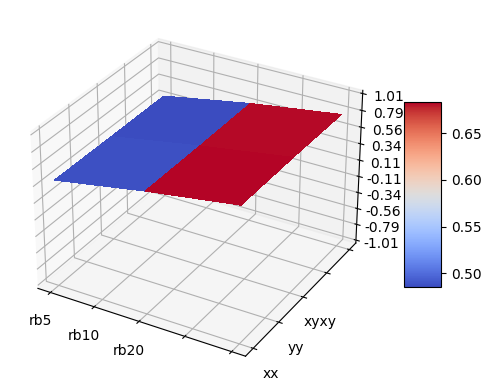

In [ ]:
X = np.arange(0, len(rb_circuits), 1)
Y = np.arange(0, len(rules), 1)
X, Y = np.meshgrid(X, Y)
Z = np.array([[ddd_results[(i, j)][2] for i in X[0]] for j in Y[:, 0]])

plot_surface(X, Y, Z, x_labels=list(rb_circuits.keys()), y_labels=list(rules.keys()))

In [ ]:
plot_surface_interactive(X, Y, Z)

In [ ]:
print(f"Max Mitigated Value: {max(list(ddd_results.values()), key=lambda x: x[1])} ")
print(f"Min Error %: {min(list(ddd_results.values()), key=lambda x: x[2])[2]}")
print(f"Min REM: {min(list(ddd_results.values()), key=lambda x: x[3])[3]}")

Max Mitigated Value: [2.0, 1.2429999999999999, 0.37850000000000006, 0.984139365574623] 
Min Error %: 0.37850000000000006
Min REM: 0.9721583652618138


In [ ]:
print(f"Min Error %: {min(list(ddd_results.values()), key=lambda x: x[2])}")

Min Error %: [2.0, 1.2429999999999999, 0.37850000000000006, 0.984139365574623]


### ZNE

In [ ]:
zne_results = {}

print("\n================ ZNE ================\n")
for i, (circuit_name, circuit) in enumerate(rb_circuits.items()):
    for j, (fold_name, scale_noise) in enumerate(folds.items()):
        print(f"({i}, {j}) => Circuit: {circuit_name}, Fold: {fold_name}")

        executor = zne.mitigate_executor(
            execute,
            observable=observable,
            scale_noise=scale_noise
        )

        result = executor(circuit)

        ideal_value = raw.execute(circuit, partial(execute, noise_level=0, p0=0, p1=0), observable).real
        noisy_value = raw.execute(circuit, execute, observable).real
        mitiq_value = result.real
        error = abs((ideal_value - mitiq_value) / ideal_value)
        rem_value = abs((ideal_value - mitiq_value) / (ideal_value - noisy_value))
        zne_results[(i, j)] = [ideal_value, mitiq_value, error, rem_value]

        print(f"Mitigated value: {mitiq_value:.3f}")
        print(f"Error w Mitiq: {error:.3f}")
        print(f"REM w  Mitiq: {rem_value:.3f}")
        print("\n")


================ ZNE ================

(0, 0) => Circuit: rb5, Fold: local
Mitigated value: 1.899
Error w Mitiq: 0.050
REM w  Mitiq: 0.132


(0, 1) => Circuit: rb5, Fold: all
Mitigated value: 0.631
Error w Mitiq: 0.685
REM w  Mitiq: 1.778


(0, 2) => Circuit: rb5, Fold: global
Mitigated value: 1.939
Error w Mitiq: 0.031
REM w  Mitiq: 0.078


(1, 0) => Circuit: rb10, Fold: local
Mitigated value: 1.710
Error w Mitiq: 0.145
REM w  Mitiq: 0.242


(1, 1) => Circuit: rb10, Fold: all
Mitigated value: 0.167
Error w Mitiq: 0.916
REM w  Mitiq: 1.598


(1, 2) => Circuit: rb10, Fold: global
Mitigated value: 1.470
Error w Mitiq: 0.265
REM w  Mitiq: 0.448


(2, 0) => Circuit: rb20, Fold: local
Mitigated value: 1.070
Error w Mitiq: 0.465
REM w  Mitiq: 0.594


(2, 1) => Circuit: rb20, Fold: all
Mitigated value: 0.124
Error w Mitiq: 0.938
REM w  Mitiq: 1.229


(2, 2) => Circuit: rb20, Fold: global
Mitigated value: 1.021
Error w Mitiq: 0.489
REM w  Mitiq: 0.637




<ipython-input-7-80b21e089ec6>:22: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-7-80b21e089ec6>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



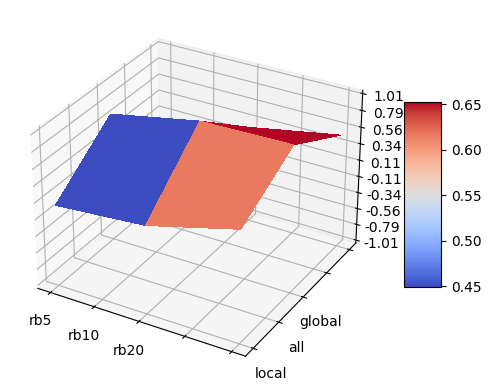

In [ ]:
X = np.arange(0, len(rb_circuits), 1)
Y = np.arange(0, len(folds), 1)
X, Y = np.meshgrid(X, Y)
Z = np.array([[zne_results[(i, j)][2] for i in X[0]] for j in Y[:, 0]])

plot_surface(X, Y, Z, x_labels=list(rb_circuits.keys()), y_labels=list(folds.keys()))

In [ ]:
plot_surface_interactive(X, Y, Z)

In [ ]:
print(f"Max Mitigated Value: {max(list(zne_results.values()), key=lambda x: x[1])} ")
print(f"Min Error %: {min(list(zne_results.values()), key=lambda x: x[2])[2]}")
print(f"Min REM: {min(list(zne_results.values()), key=lambda x: x[3])[3]}")

Max Mitigated Value: [2.0, 1.9386000000000019, 0.03069999999999906, 0.07780030410542083] 
Min Error %: 0.03069999999999906
Min REM: 0.07780030410542083


In [ ]:
print(f"Min Error %: {min(list(zne_results.values()), key=lambda x: x[2])}")

Min Error %: [2.0, 1.9386000000000019, 0.03069999999999906, 0.07780030410542083]


### REM

In [ ]:
from mitiq import rem

rem_results = {}

print("\n================ REM ================\n")
for i, (circuit_name, circuit) in enumerate(rb_circuits.items()):
    for j, prob in enumerate(probs):
        print(f"({i}, {j}) => Circuit: {circuit_name}, Probability: {prob}")

        p0 = p1 = prob
        icm = rem.generate_inverse_confusion_matrix(2, p0, p1)
        executor = rem.mitigate_executor(
            execute,
            inverse_confusion_matrix=icm
        )

        result = observable.expectation(circuit, executor)

        ideal_value = raw.execute(circuit, partial(execute, noise_level=0, p0=0, p1=0), observable).real
        noisy_value = raw.execute(circuit, execute, observable).real
        mitiq_value = result.real
        error = abs((ideal_value - mitiq_value) / ideal_value)
        rem_value = abs((ideal_value - mitiq_value) / (ideal_value - noisy_value))
        rem_results[(i, j)] = [ideal_value, mitiq_value, error, rem_value]

        print(f"Mitigated value: {mitiq_value:.3f}")
        print(f"Error w Mitiq: {error:.3f}")
        print(f"REM w  Mitiq: {rem_value:.3f}")
        print("\n")


================ REM ================

(0, 0) => Circuit: rb5, Probability: 0.1
Mitigated value: 1.524
Error w Mitiq: 0.238
REM w  Mitiq: 0.609


(0, 1) => Circuit: rb5, Probability: 0.01
Mitigated value: 1.276
Error w Mitiq: 0.362
REM w  Mitiq: 0.915


(0, 2) => Circuit: rb5, Probability: 0.05
Mitigated value: 1.375
Error w Mitiq: 0.312
REM w  Mitiq: 0.802


(0, 3) => Circuit: rb5, Probability: 0.001
Mitigated value: 1.212
Error w Mitiq: 0.394
REM w  Mitiq: 1.025


(0, 4) => Circuit: rb5, Probability: 0.005
Mitigated value: 1.234
Error w Mitiq: 0.383
REM w  Mitiq: 0.981


(1, 0) => Circuit: rb10, Probability: 0.1
Mitigated value: 1.029
Error w Mitiq: 0.486
REM w  Mitiq: 0.803


(1, 1) => Circuit: rb10, Probability: 0.01
Mitigated value: 0.850
Error w Mitiq: 0.575
REM w  Mitiq: 0.971


(1, 2) => Circuit: rb10, Probability: 0.05
Mitigated value: 0.894
Error w Mitiq: 0.553
REM w  Mitiq: 0.943


(1, 3) => Circuit: rb10, Probability: 0.001
Mitigated value: 0.834
Error w Mitiq: 0.583
REM w

<ipython-input-7-80b21e089ec6>:22: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-7-80b21e089ec6>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



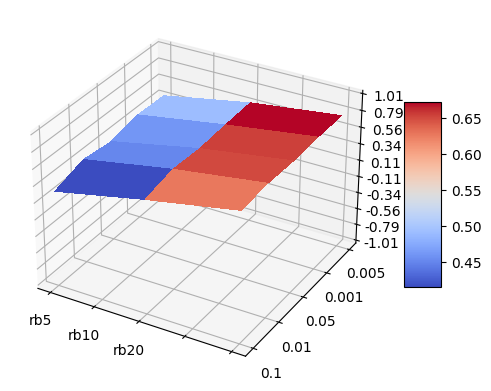

In [ ]:
X = np.arange(0, len(rb_circuits), 1)
Y = np.arange(0, len(probs), 1)
X, Y = np.meshgrid(X, Y)
Z = np.array([[rem_results[(i, j)][2] for i in X[0]] for j in Y[:, 0]])

plot_surface(X, Y, Z, x_labels=list(rb_circuits.keys()), y_labels=probs)

In [ ]:
plot_surface_interactive(X, Y, Z)

In [ ]:
print(f"Max Mitigated Value: {max(list(rem_results.values()), key=lambda x: x[1])} ")
print(f"Min Error %: {min(list(rem_results.values()), key=lambda x: x[2])[2]}")
print(f"Min REM: {min(list(rem_results.values()), key=lambda x: x[3])[3]}")

Max Mitigated Value: [2.0, 1.524, 0.238, 0.6088513686364798] 
Min Error %: 0.238
Min REM: 0.6088513686364798


In [ ]:
print(f"Min Error %: {min(list(rem_results.values()), key=lambda x: x[2])}")

Min Error %: [2.0, 1.524, 0.238, 0.6088513686364798]


### REM + ZNE (Local)

In [ ]:
rem_zne_local_results = {}

print("\n================ REM + ZNE (Local) ================\n")
for i, (circuit_name, circuit) in enumerate(rb_circuits.items()):
    for j, prob in enumerate(probs):
        print(f"({i}, {j}) => Circuit: {circuit_name}, Probability: {prob}")

        p0 = p1 = prob
        icm = rem.generate_inverse_confusion_matrix(2, p0, p1)
        executor = rem.mitigate_executor(
            execute,
            inverse_confusion_matrix=icm
        )
        # result = observable.expectation(circuit, executor)

        executor = zne.mitigate_executor(
            executor,
            observable=observable,
            scale_noise=folds["local"]
        )

        result = executor(circuit)

        ideal_value = raw.execute(circuit, partial(execute, noise_level=0, p0=0, p1=0), observable).real
        noisy_value = raw.execute(circuit, execute, observable).real
        mitiq_value = result.real
        error = abs((ideal_value - mitiq_value) / ideal_value)
        rem_value = abs((ideal_value - mitiq_value) / (ideal_value - noisy_value))
        rem_zne_local_results[(i, j)] = [ideal_value, mitiq_value, error, rem_value]

        print(f"Mitigated value: {mitiq_value:.3f}")
        print(f"Error w Mitiq: {error:.3f}")
        print(f"REM w  Mitiq: {rem_value:.3f}")
        print("\n")


================ REM + ZNE (Local) ================

(0, 0) => Circuit: rb5, Probability: 0.1
Mitigated value: 2.297
Error w Mitiq: 0.149
REM w  Mitiq: 0.383


(0, 1) => Circuit: rb5, Probability: 0.01
Mitigated value: 1.688
Error w Mitiq: 0.156
REM w  Mitiq: 0.396


(0, 2) => Circuit: rb5, Probability: 0.05
Mitigated value: 2.129
Error w Mitiq: 0.065
REM w  Mitiq: 0.168


(0, 3) => Circuit: rb5, Probability: 0.001
Mitigated value: 1.877
Error w Mitiq: 0.062
REM w  Mitiq: 0.161


(0, 4) => Circuit: rb5, Probability: 0.005
Mitigated value: 1.680
Error w Mitiq: 0.160
REM w  Mitiq: 0.408


(1, 0) => Circuit: rb10, Probability: 0.1
Mitigated value: 2.070
Error w Mitiq: 0.035
REM w  Mitiq: 0.059


(1, 1) => Circuit: rb10, Probability: 0.01
Mitigated value: 1.759
Error w Mitiq: 0.120
REM w  Mitiq: 0.209


(1, 2) => Circuit: rb10, Probability: 0.05
Mitigated value: 1.826
Error w Mitiq: 0.087
REM w  Mitiq: 0.148


(1, 3) => Circuit: rb10, Probability: 0.001
Mitigated value: 1.634
Error w Miti

<ipython-input-7-80b21e089ec6>:22: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-7-80b21e089ec6>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



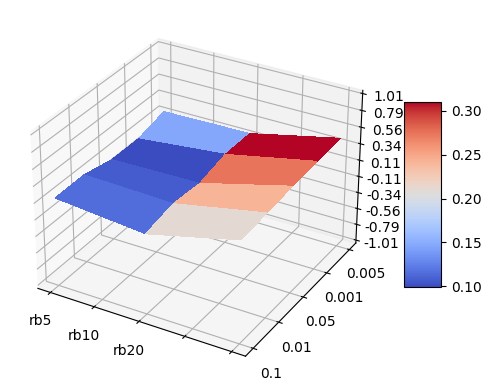

In [ ]:
X = np.arange(0, len(rb_circuits), 1)
Y = np.arange(0, len(probs), 1)
X, Y = np.meshgrid(X, Y)
Z = np.array([[rem_zne_local_results[(i, j)][2] for i in X[0]] for j in Y[:, 0]])

plot_surface(X, Y, Z, x_labels=list(rb_circuits.keys()), y_labels=probs)

In [ ]:
plot_surface_interactive(X, Y, Z)

In [ ]:
print(f"Max Mitigated Value: {max(list(rem_zne_local_results.values()), key=lambda x: x[1])} ")
print(f"Min Error %: {min(list(rem_zne_local_results.values()), key=lambda x: x[2])[2]}")
print(f"Min REM: {min(list(rem_zne_local_results.values()), key=lambda x: x[3])[3]}")

Max Mitigated Value: [2.0, 2.297200000000002, 0.14860000000000095, 0.3825952626158623] 
Min Error %: 0.035000000000001474
Min REM: 0.05887300252313116


In [ ]:
print(f"Min Error %: {min(list(rem_zne_local_results.values()), key=lambda x: x[2])}")

Min Error %: [2.0, 2.070000000000003, 0.035000000000001474, 0.05887300252313116]


### REM + ZNE (Global)

In [ ]:
rem_zne_global_results = {}

print("\n================ REM + ZNE (Global) ================\n")
for i, (circuit_name, circuit) in enumerate(rb_circuits.items()):
    for j, prob in enumerate(probs):
        print(f"({i}, {j}) => Circuit: {circuit_name}, Probability: {prob}")

        p0 = p1 = prob
        icm = rem.generate_inverse_confusion_matrix(2, p0, p1)
        executor = rem.mitigate_executor(
            execute,
            inverse_confusion_matrix=icm
        )
        # result = observable.expectation(circuit, executor)

        executor = zne.mitigate_executor(
            executor,
            observable=observable,
            scale_noise=folds["global"]
        )

        result = executor(circuit)

        ideal_value = raw.execute(circuit, partial(execute, noise_level=0, p0=0, p1=0), observable).real
        noisy_value = raw.execute(circuit, execute, observable).real
        mitiq_value = result.real
        error = abs((ideal_value - mitiq_value) / ideal_value)
        rem_value = abs((ideal_value - mitiq_value) / (ideal_value - noisy_value))
        rem_zne_global_results[(i, j)] = [ideal_value, mitiq_value, error, rem_value]

        print(f"Mitigated value: {mitiq_value:.3f}")
        print(f"Error w Mitiq: {error:.3f}")
        print(f"REM w  Mitiq: {rem_value:.3f}")
        print("\n")


================ REM + ZNE (Global) ================

(0, 0) => Circuit: rb5, Probability: 0.1
Mitigated value: 2.189
Error w Mitiq: 0.095
REM w  Mitiq: 0.252


(0, 1) => Circuit: rb5, Probability: 0.01
Mitigated value: 1.899
Error w Mitiq: 0.051
REM w  Mitiq: 0.134


(0, 2) => Circuit: rb5, Probability: 0.05
Mitigated value: 1.976
Error w Mitiq: 0.012
REM w  Mitiq: 0.031


(0, 3) => Circuit: rb5, Probability: 0.001
Mitigated value: 1.858
Error w Mitiq: 0.071
REM w  Mitiq: 0.184


(0, 4) => Circuit: rb5, Probability: 0.005
Mitigated value: 1.702
Error w Mitiq: 0.149
REM w  Mitiq: 0.382


(1, 0) => Circuit: rb10, Probability: 0.1
Mitigated value: 2.025
Error w Mitiq: 0.012
REM w  Mitiq: 0.021


(1, 1) => Circuit: rb10, Probability: 0.01
Mitigated value: 1.563
Error w Mitiq: 0.218
REM w  Mitiq: 0.368


(1, 2) => Circuit: rb10, Probability: 0.05
Mitigated value: 1.566
Error w Mitiq: 0.217
REM w  Mitiq: 0.367


(1, 3) => Circuit: rb10, Probability: 0.001
Mitigated value: 1.372
Error w Mit

<ipython-input-7-80b21e089ec6>:22: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-7-80b21e089ec6>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



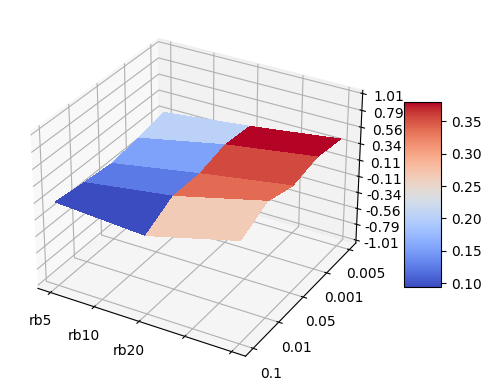

In [ ]:
X = np.arange(0, len(rb_circuits), 1)
Y = np.arange(0, len(probs), 1)
X, Y = np.meshgrid(X, Y)
Z = np.array([[rem_zne_global_results[(i, j)][2] for i in X[0]] for j in Y[:, 0]])

plot_surface(X, Y, Z, x_labels=list(rb_circuits.keys()), y_labels=probs)

In [ ]:
plot_surface_interactive(X, Y, Z)

In [ ]:
print(f"Max Mitigated Value: {max(list(rem_zne_global_results.values()), key=lambda x: x[1])} ")
print(f"Min Error %: {min(list(rem_zne_global_results.values()), key=lambda x: x[2])[2]}")
print(f"Min REM: {min(list(rem_zne_global_results.values()), key=lambda x: x[3])[3]}")

Max Mitigated Value: [2.0, 2.1894000000000022, 0.09470000000000112, 0.2515272244355939] 
Min Error %: 0.011899999999999467
Min REM: 0.02072800808897948


In [ ]:
print(f"Min Error %: {min(list(rem_zne_global_results.values()), key=lambda x: x[2])}")

Min Error %: [2.0, 1.976200000000001, 0.011899999999999467, 0.030781169167096393]


### REM + DDD

In [ ]:
rem_ddd_results = {}

print("\n================ REM + DDD ================\n")
for i, (circuit_name, circuit) in enumerate(rb_circuits.items()):
    for j, prob in enumerate(probs):
        print(f"({i}, {j}) => Circuit: {circuit_name}, Probability: {prob}")

        p0 = p1 = prob
        icm = rem.generate_inverse_confusion_matrix(2, p0, p1)
        executor = rem.mitigate_executor(
            execute,
            inverse_confusion_matrix=icm
        )
        # result = observable.expectation(circuit, executor)

        executor = ddd.mitigate_executor(
            executor,
            observable=observable,
            rule=xx
        )

        result = executor(circuit)

        ideal_value = raw.execute(circuit, partial(execute, noise_level=0, p0=0, p1=0), observable).real
        noisy_value = raw.execute(circuit, execute, observable).real
        mitiq_value = result.real
        error = abs((ideal_value - mitiq_value) / ideal_value)
        rem_value = abs((ideal_value - mitiq_value) / (ideal_value - noisy_value))
        rem_ddd_results[(i, j)] = [ideal_value, mitiq_value, error, rem_value]

        print(f"Mitigated value: {mitiq_value:.3f}")
        print(f"Error w Mitiq: {error:.3f}")
        print(f"REM w  Mitiq: {rem_value:.3f}")
        print("\n")


================ REM + DDD ================

(0, 0) => Circuit: rb5, Probability: 0.1
Mitigated value: 1.552
Error w Mitiq: 0.224
REM w  Mitiq: 0.590


(0, 1) => Circuit: rb5, Probability: 0.01
Mitigated value: 1.255
Error w Mitiq: 0.373
REM w  Mitiq: 0.961


(0, 2) => Circuit: rb5, Probability: 0.05
Mitigated value: 1.388
Error w Mitiq: 0.306
REM w  Mitiq: 0.789


(0, 3) => Circuit: rb5, Probability: 0.001
Mitigated value: 1.220
Error w Mitiq: 0.390
REM w  Mitiq: 0.991


(0, 4) => Circuit: rb5, Probability: 0.005
Mitigated value: 1.259
Error w Mitiq: 0.371
REM w  Mitiq: 0.963


(1, 0) => Circuit: rb10, Probability: 0.1
Mitigated value: 1.041
Error w Mitiq: 0.480
REM w  Mitiq: 0.811


(1, 1) => Circuit: rb10, Probability: 0.01
Mitigated value: 0.862
Error w Mitiq: 0.569
REM w  Mitiq: 0.955


(1, 2) => Circuit: rb10, Probability: 0.05
Mitigated value: 0.903
Error w Mitiq: 0.548
REM w  Mitiq: 0.950


(1, 3) => Circuit: rb10, Probability: 0.001
Mitigated value: 0.885
Error w Mitiq: 0.557

<ipython-input-7-80b21e089ec6>:22: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-7-80b21e089ec6>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



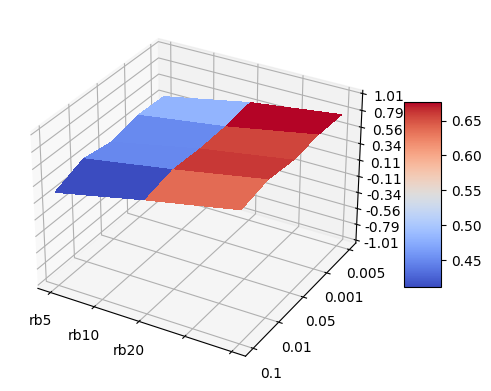

In [ ]:
X = np.arange(0, len(rb_circuits), 1)
Y = np.arange(0, len(probs), 1)
X, Y = np.meshgrid(X, Y)
Z = np.array([[rem_ddd_results[(i, j)][2] for i in X[0]] for j in Y[:, 0]])

plot_surface(X, Y, Z, x_labels=list(rb_circuits.keys()), y_labels=probs)

In [ ]:
plot_surface_interactive(X, Y, Z)

In [ ]:
print(f"Max Mitigated Value: {max(list(rem_ddd_results.values()), key=lambda x: x[1])} ")
print(f"Min Error %: {min(list(rem_ddd_results.values()), key=lambda x: x[2])[2]}")
print(f"Min REM: {min(list(rem_ddd_results.values()), key=lambda x: x[3])[3]}")

Max Mitigated Value: [2.0, 1.552, 0.22399999999999998, 0.5896288496972887] 
Min Error %: 0.22399999999999998
Min REM: 0.5896288496972887
